#Find the match points

In [1]:
import numpy as np
import skimage
import skimage.io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import random
from skimage.transform import ProjectiveTransform, warp

In [2]:
def get_sift_data(img):

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):

    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

In [3]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    dist1 = []
    dist2 = []
    dist3 = []
    for i in range(dist.shape[0]):
        dist1.append(min(dist[i,:]))
    for j in range(dist.shape[1]):
        dist2.append(min(dist[:,j]))
    for i in range(len(dist1)):
        for j in range(len(dist2)):
            if dist1[i] == dist2[j]:
                dist3.append([dist1[i],i,j])
    dist3 = sorted(dist3)[:num_matches]
    data = []
    for item in dist3:
        x1, y1 = kp1[item[1]].pt
        x2, y2 = kp2[item[2]].pt
        data.append([x1, y1, x2, y2])
    data = np.array(data, dtype = 'int')
    return data

def residual(match, h):
    p1 = np.transpose(np.matrix([match[0], match[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([match[2], match[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def ransac(data, threshold = 0.8, iteration = 1000):
    max_linear = []
    best_model = None
    best_residual = None
    for i in range(iteration):
        match1 = data[random.randrange(0, len(data))]
        match2 = data[random.randrange(0, len(data))]
        fourMatches = np.vstack((match1, match2))
        match3 = data[random.randrange(0, len(data))]
        fourMatches = np.vstack((fourMatches, match3))
        match4 = data[random.randrange(0, len(data))]
        fourMatches = np.vstack((fourMatches, match4))

        h = compute_homography(fourMatches)
        inliers = []
        
        all_residual = 0
        for i in range(len(data)):
            r = residual(data[i], h)
            if r < 5:
                inliers.append(data[i])
            all_residual += r

        if len(inliers) > len(max_linear):
            max_linear = inliers
            best_model = h
            best_residual = all_residual / len(data)

        if len(max_linear) > (len(data)*threshold):
            break

    return best_model, max_linear, best_residual

def compute_homography(fourMatches):

    A = []
    for match in fourMatches:
        p1 = np.matrix([match[0], match[1], 1])
        p2 = np.matrix([match[2], match[3], 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        A.append(a1)
        A.append(a2)

    A = np.matrix(A)

    u, s, v = np.linalg.svd(A)
    h = np.reshape(v[8], (3, 3))
    h = (1/h.item(8)) * h
    return h

In [4]:
img1 = cv2.imread('left.jpg',0)
img2 = cv2.imread('right.jpg',0)

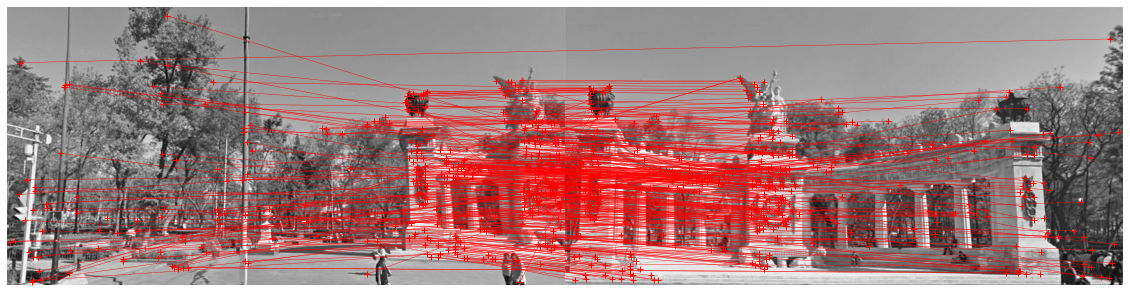

In [5]:
data = get_best_matches(img1, img2, 400)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.jpg', bbox_inches='tight')

# Display the inlier matching, report the average residual

Best model: [[ 3.95210596e+00 -4.31664405e-01 -1.97205169e+03]
 [ 8.30549608e-01  3.47113578e+00 -6.26790600e+02]
 [ 2.84638726e-03  1.44263443e-04  1.00000000e+00]]
Average residual: 373.0473927490135
Homography inliers: 134


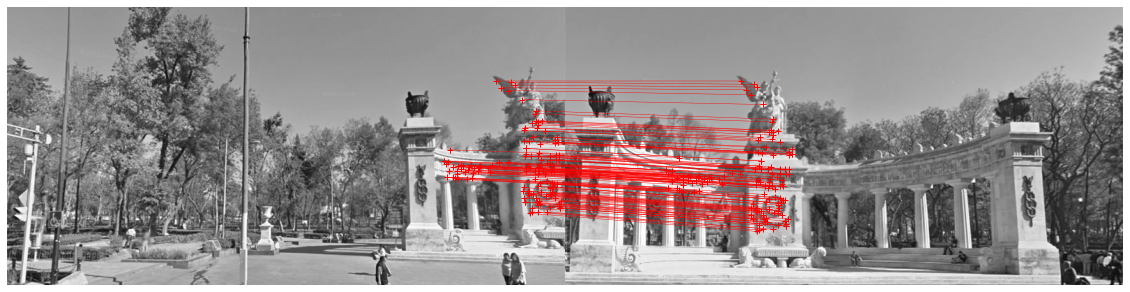

In [6]:
best_model, max_inliers, best_model_errors = ransac(data)
max_inliers = np.array(max_inliers)
print("Best model:", best_model)
print("Average residual:", np.average(best_model_errors))
print("Homography inliers:", len(max_inliers))
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, max_inliers)
fig.savefig('ransac.jpg', bbox_inches='tight')

#Combine two image

In [7]:
from pylab import *
from PIL import Image

In [8]:
def homo_to_norm(homo_coords):
    return np.array((homo_coords[0] / homo_coords[2], homo_coords[1] / homo_coords[2]))

def warp_point(normal_coords, homo_matrix):
    # convert coordinates to homogenous coordinates
    homo_coords = np.array(normal_coords + (1,))
    # compute Hx, projected coordinates of homo_coords
    proj_homo_coords = np.matmul(homo_matrix, homo_coords)
    # convert projected homo coordinates back to normal coordinates
    return homo_to_norm(proj_homo_coords) 

def warp_images(H, img1, img2):
    #gray scale
    img1 = cv2.imread('left.jpg',0) 
    img2 = cv2.imread('right.jpg',0) 
    #color image
    rgb_img1 = cv2.imread('left.jpg') 
    rgb_img2 = cv2.imread('right.jpg') 

    max_y, max_x = np.array(img1).shape
    corners = [(0, 0), (max_x, 0), (0, max_y),  (max_x, max_y)]

    best_model_arr = best_model.getA1()
    best_model_arr = best_model_arr.reshape(3, 3)

    transformed_coords = np.array([warp_point(four_corner, best_model_arr) for four_corner in corners])

    min_x = np.min(transformed_coords[:,0])
    min_y = np.min(transformed_coords[:,1])
    max_x = np.max(transformed_coords[:,0])
    max_y = np.max(transformed_coords[:,1])
    height = int(max_y - min_y)
    width = int(max_x - min_x)

    # dimensions are max of shifted warped img1 and shifted img2
    dims = (max(height, int(img1.shape[0] - min_y)), max(width, int(img1.shape[1] - min_x)))

    # form product of translation and homography matrix to get img1's transform
    translation_matrix = np.array([[1, 0, -min_x],[0, 1, -min_y],[0, 0, 1]])
    translate_warp_matrix = np.matmul(translation_matrix, best_model_arr)

    # warp img1 with homography and translation
    tf = skimage.transform.ProjectiveTransform(matrix=translate_warp_matrix)
    warped_img_1 = skimage.transform.warp(img1, tf.inverse, output_shape=dims)

    # warp img2 with translation only
    translation_matrix_2 = np.array([[1, 0, -min_x],[0, 1, -min_y]])
    img2_shifted = cv2.warpAffine(img2, translation_matrix_2, (dims[1], dims[0]))

    # normalize (oops)
    img2_final = img2_shifted / 255

    # shuffle rgb images
    rgb_image1_shuffled = np.transpose(rgb_img1, (2,0,1))
    rgb_image2_shuffled = np.transpose(rgb_img2, (2,0,1))

    # warp image 1
    warped_rgb_img1 = np.array([skimage.transform.warp(channel, tf.inverse, output_shape=dims) for channel in rgb_image1_shuffled])
    # translate image 2
    trans_rgb_img2 = np.array([cv2.warpAffine(channel, translation_matrix_2, (dims[1], dims[0])) for channel in rgb_image2_shuffled])

    # convert to color image
    final_img1 = np.transpose(warped_rgb_img1, (1,2,0))
    final_img2 = np.transpose(trans_rgb_img2, (1,2,0)) / 255

    # combine images
    combined_image = np.zeros(dims+(3,))
    for i in range(0, dims[0]):
        for j in range(0, dims[1]):
            img_1_pt = warped_img_1[i][j]
            img_2_pt = img2_final[i][j]
            if img_1_pt == 0 and img_2_pt != 0:
                combined_image[i][j] = final_img2[i][j]
            elif img_1_pt != 0 and img_2_pt == 0:
                combined_image[i][j] = final_img1[i][j]
            elif img_1_pt != 0 and img_2_pt != 0:
                combined_image[i][j] = final_img1[i][j] 
            else:  
                combined_image[i][j] = np.zeros(3)
    return combined_image

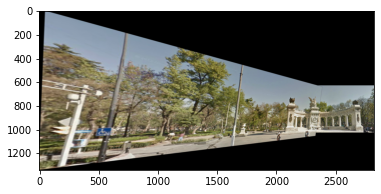

In [9]:
im = warp_images(best_model, img1, img2)
im = (im * 255).astype(np.uint8)
final_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(final_image)
plt.show()
im = Image.fromarray(final_image)
im.save("stitched_img.jpg")